In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer

model_name = "internlm/Intern-S1-FP8"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.tokenize(':(A)')

/vast/projects/xia6/apex-gen/tianang/miniconda3/envs/torchtune/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
If tokenization with SMILES formula is of necessity, please 'pip install RDKit' for better tokenization quality.


[':(', 'A', ')']

In [2]:
tokenizer.tokenize('\n(A)')

['Ċ', '(A', ')']

In [2]:
record = {
    "instruction": "计算这些物品的总费用。",
    "input": "汽车-3000，衣服-100，书-20",
    "output": "总费用为 3120。"
}
user_text = (record["instruction"] + ("\n" + record["input"] if record.get("input") else "")).strip()
messages = [
    # {"role": "system", "content": record.get("system", "")},   # 可无
    {"role": "user",   "content": user_text},
    {"role": "assistant", "content": record["output"]}         # 训练时 labels 只覆盖回答部分
]
rendered = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    enable_thinking=False,
    add_generation_prompt=False   # 训练样本里通常不加“等待助手回复”的尾部
)
print("===Rendered text===")
print(rendered)
print("===Rendered text===")

===Rendered text===
<|im_start|>user
计算这些物品的总费用。
汽车-3000，衣服-100，书-20<|im_end|>
<|im_start|>assistant
<think>

</think>
总费用为 3120。<|im_end|>

===Rendered text===


In [3]:
record = {
    "instruction": "计算这些物品的总费用。",
    "input": "汽车-3000，衣服-100，书-20",
    "output": "总费用为 3120。"
}

# 你自己写好的reasoning
reasoning = """1. 汽车 3000
2. 衣服 100
3. 书 20
4. 合计 3000 + 100 + 20 = 3120"""

user_text = (record["instruction"] + ("\n" + record["input"] if record.get("input") else "")).strip()

messages = [
    {"role": "user", "content": user_text},
    {
        "role": "assistant",
        "content": f"<think>\n{reasoning}\n</think>\n{record['output']}"
    }
]

rendered = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    enable_thinking=True,   # 关键：关掉它自动插空<think>的功能
    add_generation_prompt=False
)

print(rendered)


<|im_start|>system
You are an expert reasoner with extensive experience in all areas. You approach problems through systematic thinking and rigorous reasoning. Your response should reflect deep understanding and precise logical thinking, making your solution path and reasoning clear to others. Please put your thinking process within <think>...</think> tags.<|im_end|>
<|im_start|>user
计算这些物品的总费用。
汽车-3000，衣服-100，书-20<|im_end|>
<|im_start|>assistant
<think>
1. 汽车 3000
2. 衣服 100
3. 书 20
4. 合计 3000 + 100 + 20 = 3120
</think>
总费用为 3120。<|im_end|>



In [7]:
tokenizer.additional_special_tokens

['<|im_start|>',
 '<|im_end|>',
 '<|object_ref_start|>',
 '<|object_ref_end|>',
 '<|box_start|>',
 '<|box_end|>',
 '<|quad_start|>',
 '<|quad_end|>',
 '<|vision_start|>',
 '<|vision_end|>',
 '<|vision_pad|>',
 '<|image_pad|>',
 '<|video_pad|>']

In [9]:
tokenizer.all_special_tokens

['<|im_end|>',
 '<|endoftext|>',
 '<|im_start|>',
 '<|object_ref_start|>',
 '<|object_ref_end|>',
 '<|box_start|>',
 '<|box_end|>',
 '<|quad_start|>',
 '<|quad_end|>',
 '<|vision_start|>',
 '<|vision_end|>',
 '<|vision_pad|>',
 '<|image_pad|>',
 '<|video_pad|>',
 '<IMG_CONTEXT>',
 '</img>',
 '<img>',
 '<video>']

In [11]:
tokenizer.get_added_vocab()

{'<|endoftext|>': 151643,
 '<|im_start|>': 151644,
 '<|im_end|>': 151645,
 '<|object_ref_start|>': 151646,
 '<|object_ref_end|>': 151647,
 '<|box_start|>': 151648,
 '<|box_end|>': 151649,
 '<|quad_start|>': 151650,
 '<|quad_end|>': 151651,
 '<|vision_start|>': 151652,
 '<|vision_end|>': 151653,
 '<|vision_pad|>': 151654,
 '<|image_pad|>': 151655,
 '<|video_pad|>': 151656,
 '<tool_call>': 151657,
 '</tool_call>': 151658,
 '<|fim_prefix|>': 151659,
 '<|fim_middle|>': 151660,
 '<|fim_suffix|>': 151661,
 '<|fim_pad|>': 151662,
 '<|repo_name|>': 151663,
 '<|file_sep|>': 151664,
 '<tool_response>': 151665,
 '</tool_response>': 151666,
 '<think>': 151667,
 '</think>': 151668,
 '<SMILES>': 151925,
 '</SMILES>': 151926,
 '<SELFIES>': 151927,
 '</SELFIES>': 151928,
 '<IUPAC>': 152441,
 '</IUPAC>': 152442,
 '<FASTA>': 152955,
 '</FASTA>': 152956,
 '<IMG_CONTEXT>': 152957,
 '<img>': 152958,
 '</img>': 152959,
 '<quad>': 152960,
 '</quad>': 152961,
 '<ref>': 152962,
 '</ref>': 152963,
 '<box>': 152

O=C(O)[C@H](Cc1cnc[nH]1)N1C(=O)c2ccccc2C1=O


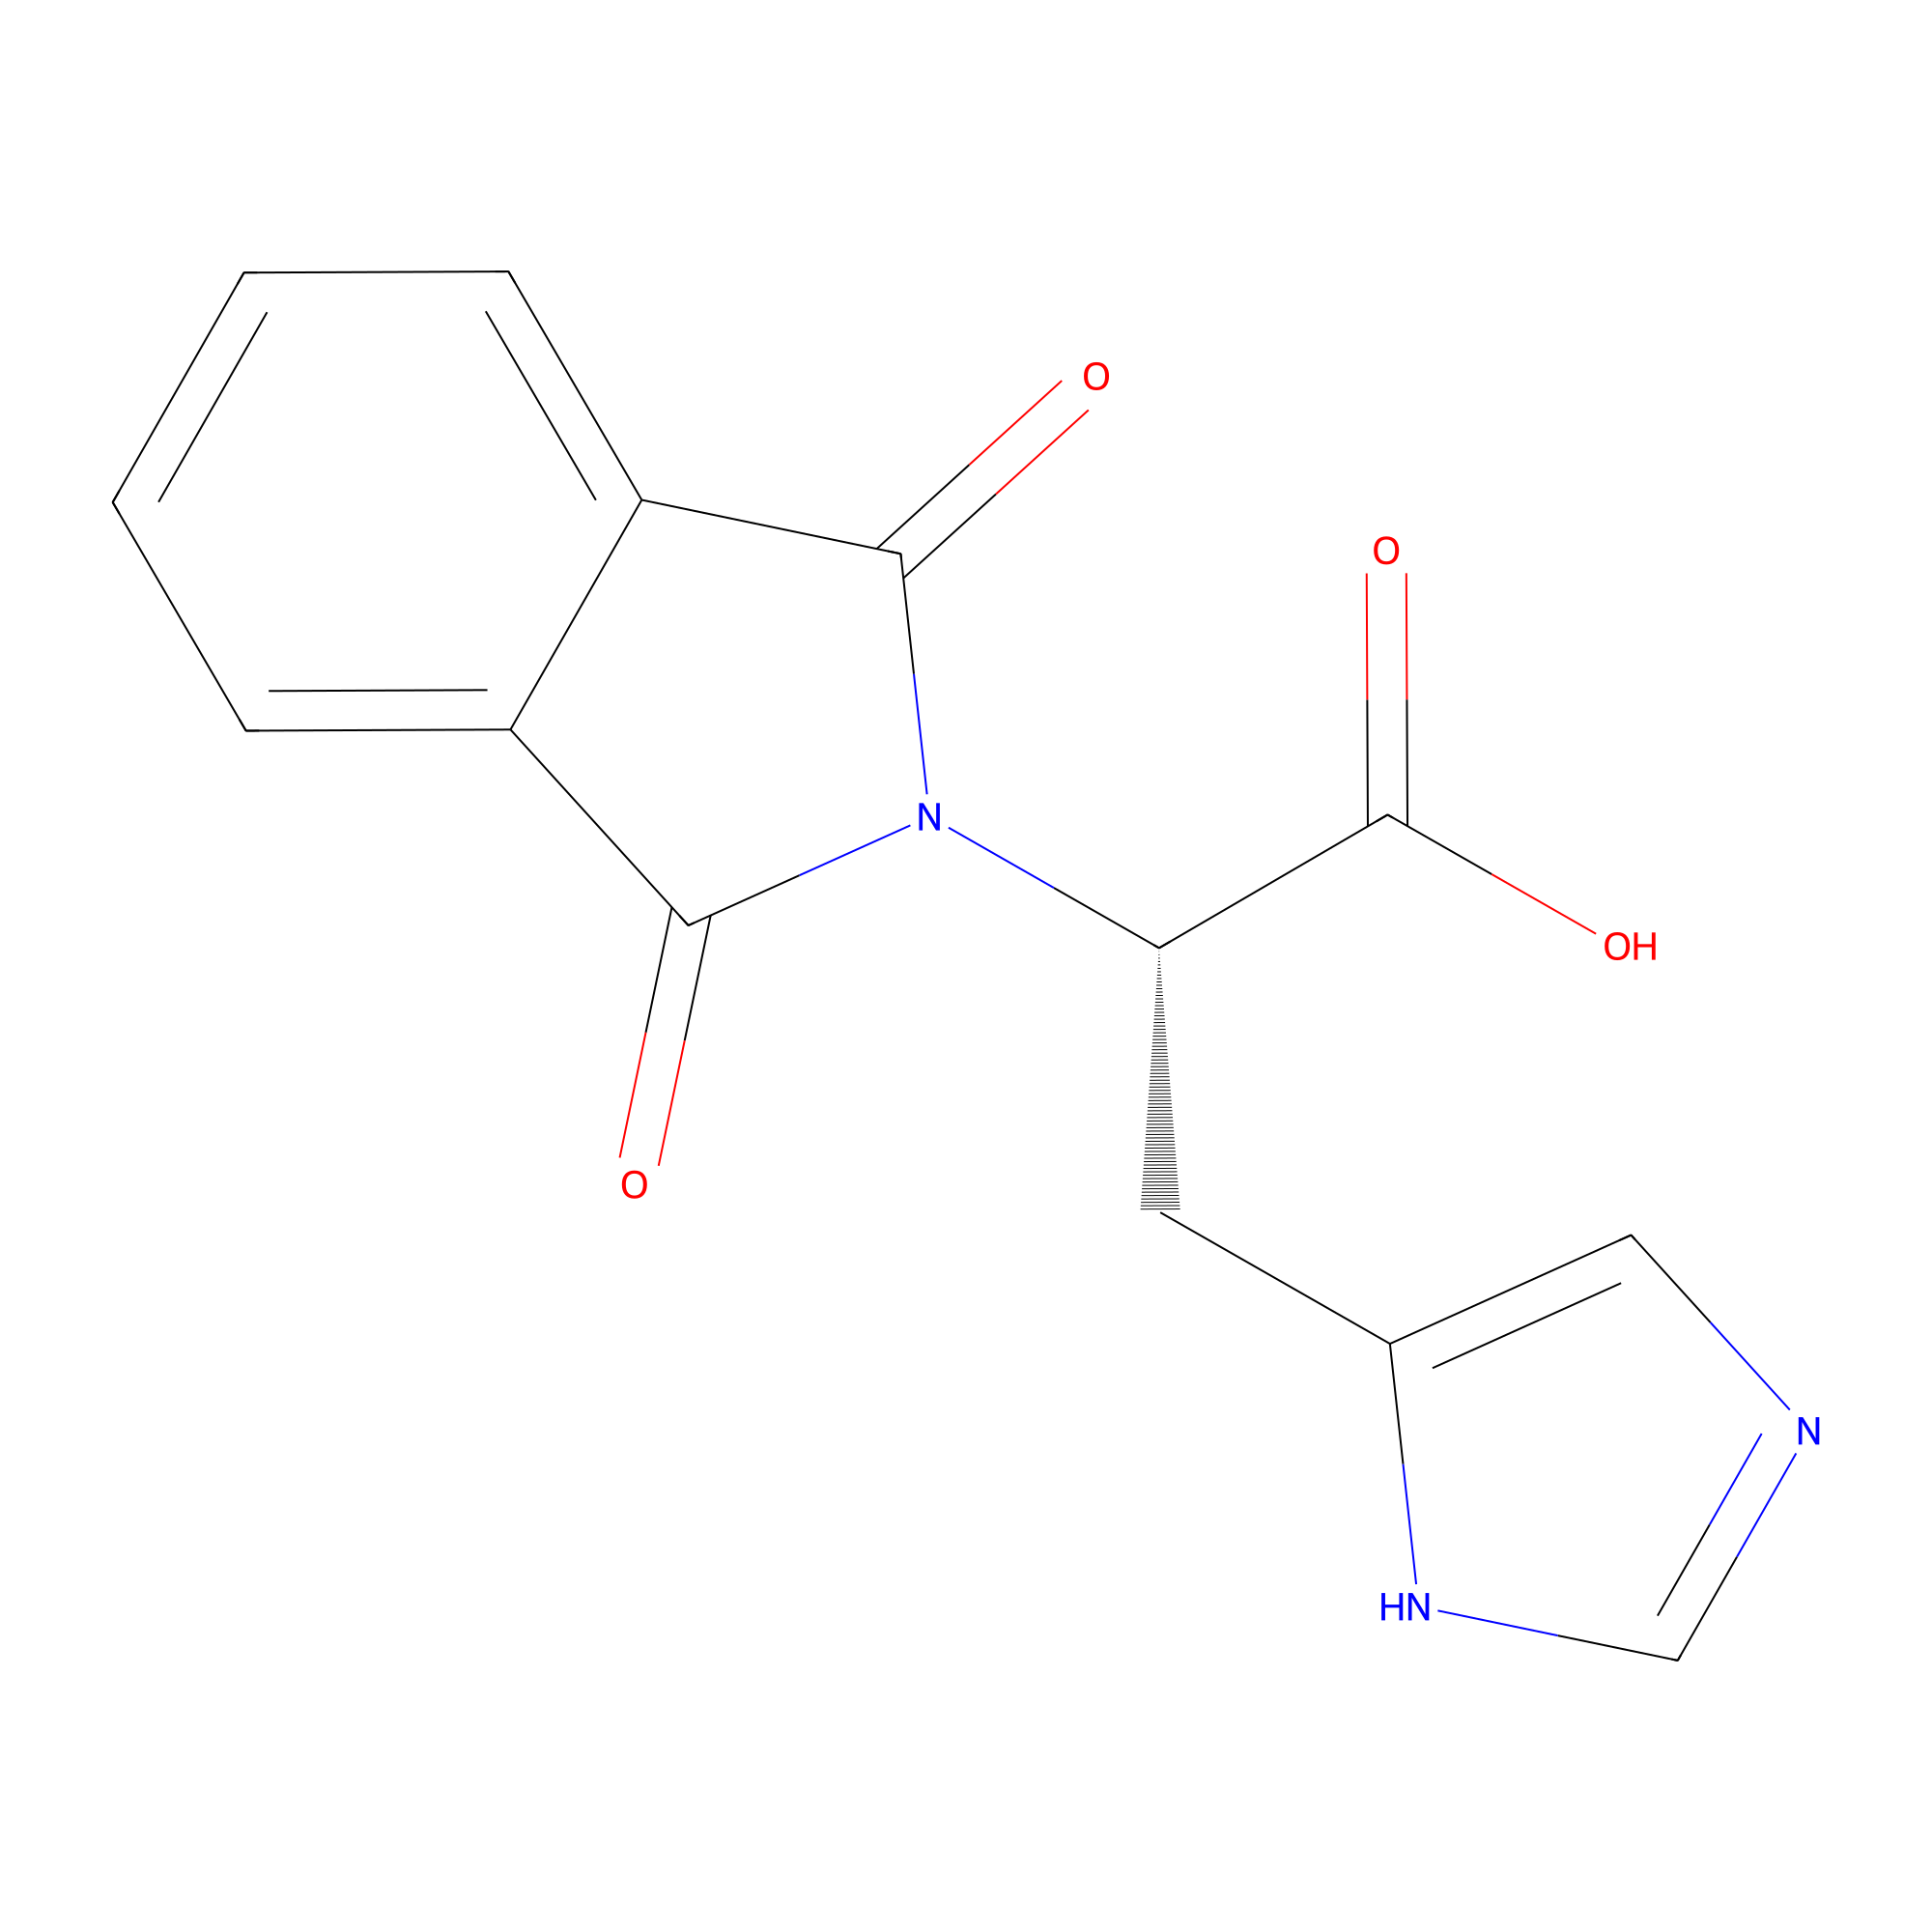

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
# import selfies as sf
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import MolDrawOptions

# 使用从 OPSIN 获得的 SMILES
smiles = "O=C(O)[C@H](Cc1cnc[nH]1)N1C(=O)c2ccccc2C1=O"
# smiles = "[C][=O][N]"
# C[N+](C)(C)CCCC[C@@H](C(=O)[O-])[NH3+]
# smiles = sf.decoder(smiles)
print(smiles)
# 创建分子对象
mol = Chem.MolFromSmiles(smiles)

rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(mol)

opts = MolDrawOptions()
# opts.reduceOverlap = True

# 绘制分子结构
img = Draw.MolToImage(mol, size=(2000, 2000))
display(img)

CC1=NOC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1


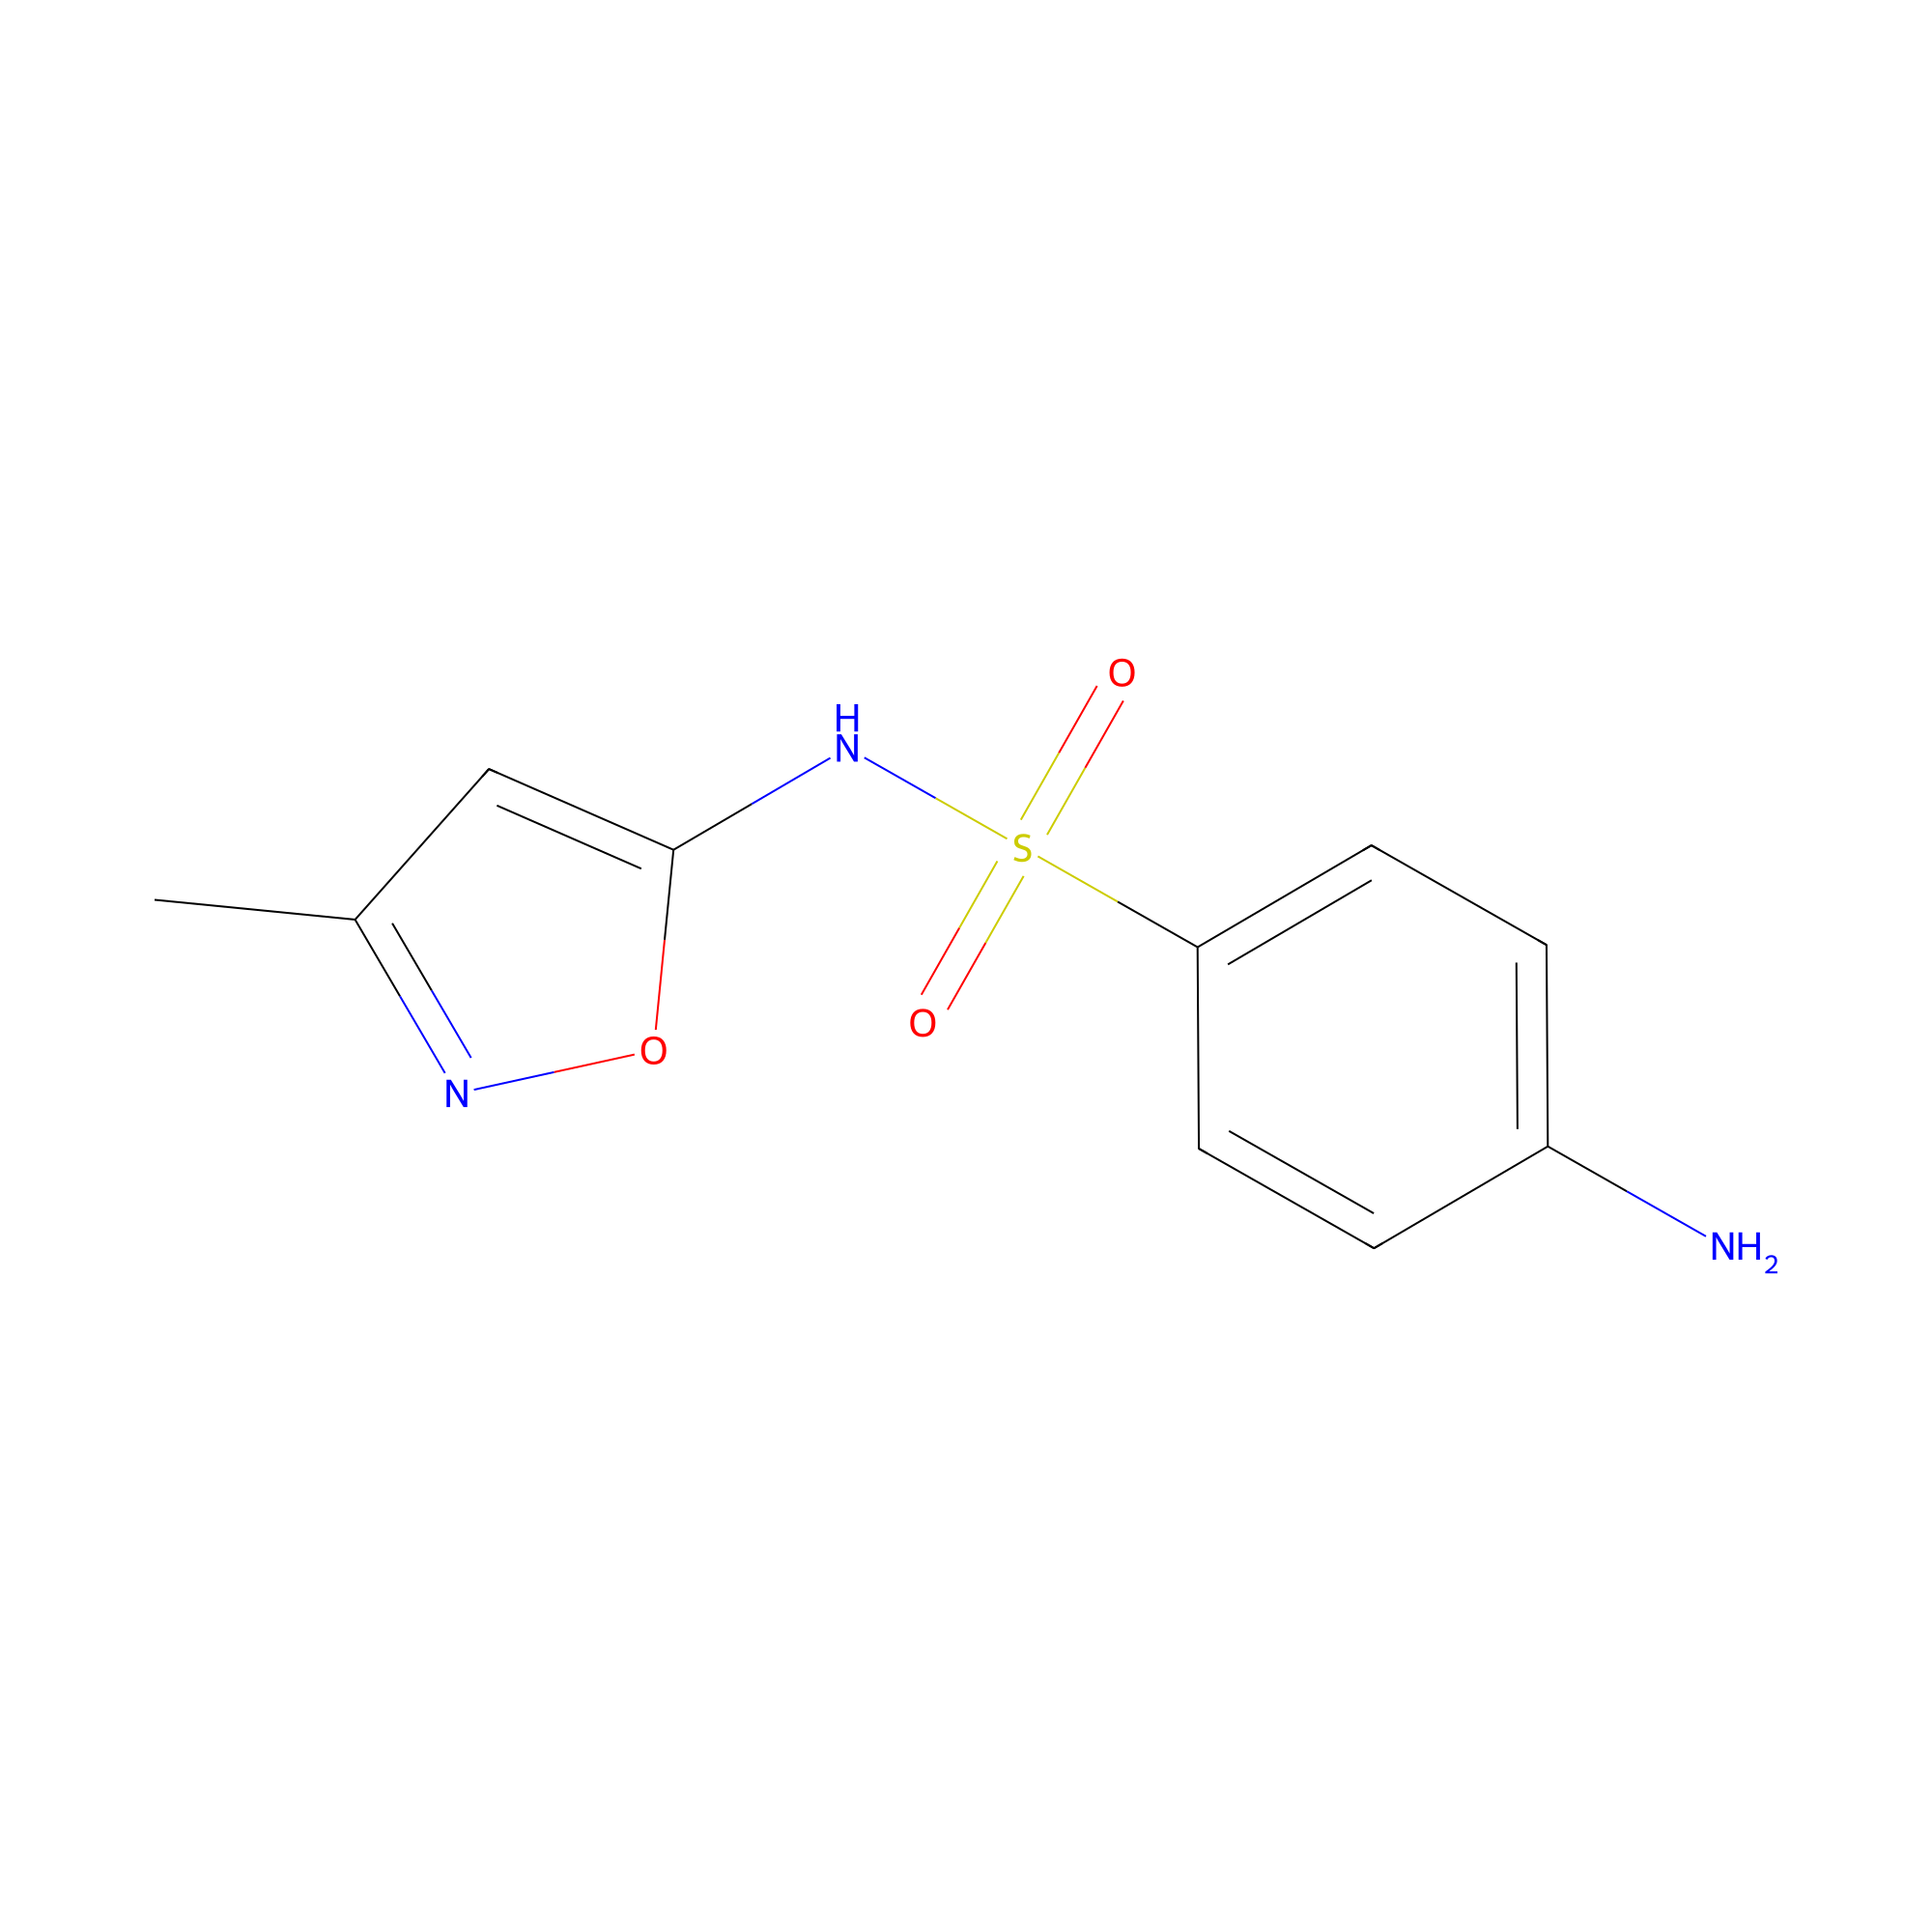

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
# import selfies as sf
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import MolDrawOptions

# 使用从 OPSIN 获得的 SMILES
smiles = "CC1=NOC(NS(=O)(=O)C2=CC=C(N)C=C2)=C1"
# smiles = "[C][=O][N]"
# C[N+](C)(C)CCCC[C@@H](C(=O)[O-])[NH3+]
# smiles = sf.decoder(smiles)
print(smiles)
# 创建分子对象
mol = Chem.MolFromSmiles(smiles)

rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(mol)

opts = MolDrawOptions()
# opts.reduceOverlap = True

# 绘制分子结构
img = Draw.MolToImage(mol, size=(2000, 2000))
display(img)

In [12]:
tokenizer.tokenize('<|im_start|>user\nInstructions: Answer the following question about drug properties.\nContext: As a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier (BBB) is the protection layer that blocks most foreign drugs. Thus the ability of a drug to penetrate the barrier to deliver to the site of action forms a crucial challenge in development of drugs for central nervous system.\nQuestion: Given a drug SMILES string, predict whether it\n(A) does not cross the BBB (B) crosses the BBB\nDrug SMILES: <SMILES>CC[C@H](C)C(=O)O[C@H]1CCC=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@H]21</SMILES>\nAnswer:<|im_end|>\n<|im_start|>assistant\n(A')[142]

'(A'

In [14]:
from tdc.single_pred import ADME
from tdc.multi_pred import PPI

ImportError: cannot import name 'AffineTransform' from 'somacore' (/home/tianang/anaconda3/envs/reasonv/lib/python3.11/site-packages/somacore/__init__.py)

In [1]:
from tdc.single_pred import ADME, Tox, QM, Epitope, Develop, CRISPROutcome, Yields
from tdc.multi_pred.ppi import PPI#, TCREpitopeBinding, TrialOutcome, PeptideMHC
from tdc.multi_pred.tcr_epi import TCREpitopeBinding
from tdc.multi_pred.trialoutcome import TrialOutcome
from tdc.multi_pred.peptidemhc import PeptideMHC
from tdc.multi_pred.dti import DTI
from tdc.multi_pred.drugsyn import DrugSyn
from tdc.multi_pred.drugres import DrugRes
from tdc.multi_pred.antibodyaff import AntibodyAff
from huggingface_hub import hf_hub_download
import json
import numpy as np
from tdc.utils import retrieve_label_name_list
print(1)

tdc_prompts_filepath = hf_hub_download(
    repo_id="google/txgemma-9b-predict",
    filename="tdc_prompts.json",
)
tdc_prompts_json = json.load(open(tdc_prompts_filepath))


# 选择一个任务和输入
task_name = "CYP1A2_Veith"  # BBB_Martins
# label_list = retrieve_label_name_list(task_name)
# print(label_list)
input_type = "{Drug SMILES}"

# SFT_data = Tox(name=task_name, label_name = label_list[2])
data = ADME(name=task_name)
# SFT_data = SFT_data.neg_sample(frac = 1)  # only for PPI dataset
split = data.get_split()
print(split['test'])
# print((split['test']['Y'].to_numpy()).sum())#[:5]
# print(split['test']['Antibody'].values)
test_drugs = split['test']['Drug']#[:5]
test_labels = split['test']['Y']#[:5]

drug_smiles = test_drugs[0]

prompt_text = tdc_prompts_json[task_name].replace(input_type, f'<SMILES>{drug_smiles}</SMILES>')
print(prompt_text)
conv = [{"role": "user", "content": [{"type": "text", "text": prompt_text}]}]
tokenizer.apply_chat_template(
            conv,
            tokenize=False,  # 让 vLLM 自己分词
            add_generation_prompt=True,  # 补上assistant起始标记
            enable_thinking=False
        )

Downloading...


1


100%|██████████| 760k/760k [00:00<00:00, 2.45MiB/s]
Loading...
Done!


         Drug_ID                                               Drug  Y
0       700531.0        O=C(O)[C@H](Cc1cnc[nH]1)N1C(=O)c2ccccc2C1=O  0
1      6270538.0            COc1ccc(CNC(=O)/C=C/c2ccc(OCCCF)cc2)cc1  0
2      3239491.0                            CC(=O)NC(O)C(=O)c1ccco1  0
3      5771786.0               CCCC/C=C/C(NC(=O)CCc1ccccc1)c1ccccc1  1
4       738566.0                      COc1cccc(CNCc2ccc(SC)cc2)c1OC  1
...          ...                                                ... ..
2511   3435952.0             O=C(Nc1nnc(SCc2c(Cl)cccc2Cl)s1)C1CCCO1  1
2512   3246557.0                    O=C(O)[C@@H](Br)[C@H](Br)C(=O)O  0
2513  16758750.0  COc1ccc(COC(=O)N/N=C2/C[C@@H](O)[C@@H](O)[C@@H...  0
2514    135349.0  CN(C(=O)Cc1ccc(Cl)c(Cl)c1)[C@@H]1CCCC[C@H]1N1C...  0
2515   2295127.0  Cc1ccc(S(=O)(=O)Oc2ccc(C3C4=C(CCCC4=O)OC4=C3C(...  0

[2516 rows x 3 columns]
Instructions: Answer the following question about drug properties.
Context: The CYP P450 genes are involved in the formatio

NameError: name 'tokenizer' is not defined

In [3]:
tdc_prompts_json['MHC1_IEDB_IMGT_Nielsen']

'Instructions: Answer the following question about peptide-MHC binding.\nContext: In the human body, T cells monitor the existing peptides and trigger an immune response if the peptide is foreign. To decide whether or not if the peptide is not foreign, the peptide must bind to a major histocompatibility complex (MHC) molecule. Therefore, predicting peptide-MHC binding affinity is pivotal for determining immunogenicity. In some experiments, the peptide binding is measured against cells that express multiple MHCs, so the peptide could be binding any one of the possible MHCs. Class 1 MHC molecules bind to peptides that are usually 8-14 amino acids long and activate CD8 T cells.\nQuestion: Given the amino acid sequence of the peptide and possible pseudo amino acid sequences of MHC 1, predict whether the peptide\n(A) does not bind to any of the MHCs (B) binds to any of the MHCs\nPeptide amino acid sequence: {Peptide amino acid sequence}\nPossible MHC pseudosequences: {Possible MHC pseudoseq

### 回归任务的模版

In [14]:
for i, template in tdc_prompts_json.items():
    if '(A)' not in template:
        print(f'task {i}:\n'+template+'\n')

task Caco2_Wang:
Instructions: Answer the following question about drug properties.
Context: The human colon epithelial cancer cell line, Caco-2, is used as an in vitro model to simulate the human intestinal tissue. The experimental result on the rate of drug passing through the Caco-2 cells can approximate the rate at which the drug permeates through the human intestinal tissue.
Question: Given a drug SMILES string, predict its normalized Caco-2 cell effective permeability from 000 to 1000, where 000 is minimum permeability and 1000 is maximum permeability.
Drug SMILES: {Drug SMILES}
Answer:

task VDss_Lombardo:
Instructions: Answer the following question about drug properties.
Context: The volume of distribution at steady state (VDss) measures the degree of a drug's concentration in body tissue compared to concentration in blood. Higher VD indicates a higher distribution in the tissue and usually indicates the drug with high lipid solubility, low plasma protein binding rate.
Question

In [18]:
list(tdc_prompts_json.keys())

['Pgp_Broccatelli',
 'Bioavailability_Ma',
 'BBB_Martins',
 'CYP2D6_Veith',
 'CYP3A4_Veith',
 'CYP2C9_Veith',
 'CYP2D6_Substrate_CarbonMangels',
 'CYP3A4_Substrate_CarbonMangels',
 'CYP2C9_Substrate_CarbonMangels',
 'hERG',
 'AMES',
 'DILI',
 'HIA_Hou',
 'Tox21_NR_AhR',
 'Tox21_NR_Aromatase',
 'Tox21_NR_AR',
 'Tox21_NR_AR_LBD',
 'Tox21_NR_ER',
 'Tox21_NR_ER_LBD',
 'Tox21_NR_PPAR_gamma',
 'Tox21_SR_ARE',
 'Tox21_SR_ATAD5',
 'Tox21_SR_HSE',
 'Tox21_SR_MMP',
 'Tox21_SR_p53',
 'PAMPA_NCATS',
 'CYP2C19_Veith',
 'CYP1A2_Veith',
 'Skin_Reaction',
 'Carcinogens_Lagunin',
 'SARSCoV2_Vitro_Touret',
 'SARSCOV2_3CLPro_Diamond',
 'HIV',
 'ClinTox',
 'orexin1_receptor_butkiewicz',
 'm1_muscarinic_receptor_agonists_butkiewicz',
 'm1_muscarinic_receptor_antagonists_butkiewicz',
 'potassium_ion_channel_kir2.1_butkiewicz',
 'kcnq2_potassium_channel_butkiewicz',
 'cav3_t_type_calcium_channels_butkiewicz',
 'choline_transporter_butkiewicz',
 'serine_threonine_kinase_33_butkiewicz',
 'tyrosyl_dna_phosphodi

In [35]:
len([name for name in list(tdc_prompts_json.keys()) if not (name.startswith('ToxCast') or name.startswith('Tox21'))])

74

In [6]:
from tdc.utils import retrieve_dataset_names

# 例：ADME 任务下的所有数据集名称
names = retrieve_dataset_names('Tox')
print(names)

['tox21', 'toxcast', 'clintox', 'herg_karim', 'herg', 'herg_central', 'dili', 'skin_reaction', 'ames', 'carcinogens_lagunin', 'ld50_zhu']


In [6]:
from tdc import metadata
from tdc.utils import retrieve_dataset_names

task2cat = metadata.get_task2category()   # {task_name: category, ...}
print(task2cat, '\n')
for task in sorted(task2cat.keys()):
    ds = retrieve_dataset_names(task)
    print(f"[{task2cat[task]}] {task}: {ds}\n")

{'Tox': 'single_pred', 'ADME': 'single_pred', 'HTS': 'single_pred', 'Epitope': 'single_pred', 'Develop': 'single_pred', 'QM': 'single_pred', 'Paratope': 'single_pred', 'Yields': 'single_pred', 'CRISPROutcome': 'single_pred', 'DTI': 'multi_pred', 'PPI': 'multi_pred', 'DDI': 'multi_pred', 'PeptideMHC': 'multi_pred', 'DrugRes': 'multi_pred', 'AntibodyAff': 'multi_pred', 'DrugSyn': 'multi_pred', 'MTI': 'multi_pred', 'GDA': 'multi_pred', 'Catalyst': 'multi_pred', 'TCR_Epitope_Binding': 'multi_pred', 'TrialOutcome': 'multi_pred', 'CellXGene': 'multi_pred', 'RetroSyn': 'generation', 'Reaction': 'generation', 'MolGen': 'generation'} 

[single_pred] ADME: ['lipophilicity_astrazeneca', 'solubility_aqsoldb', 'hydrationfreeenergy_freesolv', 'caco2_wang', 'pampa_ncats', 'approved_pampa_ncats', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'vdss_lombardo', 'cyp2c19_veith', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp1a2_veith', 'cyp2c9_veith', 'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbon

KeyError: 'TCR_Epitope_Binding'

In [7]:
from tdc import utils
from tdc.benchmark_group import admet_group

# 方式A：直接取名称列表
names = utils.retrieve_benchmark_names('ADMET_Group')
print(names)

# 方式B：实例化组对象后查看
group = admet_group(path='SFT_data/')
print(group.dataset_names)


['caco2_wang', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'lipophilicity_astrazeneca', 'solubility_aqsoldb', 'bbb_martins', 'ppbr_az', 'vdss_lombardo', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp2c9_veith', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'cyp2c9_substrate_carbonmangels', 'half_life_obach', 'clearance_microsome_az', 'clearance_hepatocyte_az', 'herg', 'ames', 'dili', 'ld50_zhu']


100%|██████████| 1.47M/1.47M [00:00<00:00, 2.08MiB/s]
Extracting zip file...
Done!


['caco2_wang', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'lipophilicity_astrazeneca', 'solubility_aqsoldb', 'bbb_martins', 'ppbr_az', 'vdss_lombardo', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp2c9_veith', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'cyp2c9_substrate_carbonmangels', 'half_life_obach', 'clearance_microsome_az', 'clearance_hepatocyte_az', 'herg', 'ames', 'dili', 'ld50_zhu']


In [5]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')
print(label_list)
from tdc.single_pred import Tox
data = Tox(name = 'herg_central', label_name = label_list[0])
split = data.get_split()
print(split['test'])

Found local copy...
Loading...


['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']


Done!


        Drug_ID                                               Drug        Y
0      17508895              Cc1c(C(=O)NCc2ccco2)cccc1[N+](=O)[O-]   9.7453
1      49647072            CC1(C(=O)O)CCC(C(=O)Nc2cccc(F)c2)C1(C)C   2.3245
2      49825891             N=c1oc2ccc(Br)cc2cc1C(=O)NCc1ccc(F)cc1   8.7043
3      49649013          O=C(O)c1cc(-c2ccccc2Cl)n(-c2cccc(Cl)c2)n1  10.2614
4      47195785         COc1cccc(OP(=O)(Nc2ccccc2)Oc2cccc(OC)c2)c1  10.3881
...         ...                                                ...      ...
61374  49737086      O=c1ccc(-c2ccc(S(=O)(=O)Nc3ccccc3Cl)o2)n[nH]1  13.7994
61375  22406625            Cc1cc(Br)ccc1SCC(=O)OCC(=O)Nc1ccccc1C#N  11.7833
61376  24821870              COc1ccc(CSC2=CS(=O)(=O)c3ccccc3N2)cc1  13.7980
61377  56463241              O=C(/C=C/C=C/c1ccc2c(c1)OCO2)N1CCCCC1   9.1216
61378   4244597  COc1cccc(-n2nnc3c(=O)n(CC(=O)N4CCCc5ccccc54)cn...  -6.2821

[61379 rows x 3 columns]


In [2]:
from tdc.single_pred import Tox
data = Tox(name = 'ToxCast')
split = data.get_split()

ValueError: Please select a label name. You can use tdc.utils.retrieve_label_name_list('toxcast') to retrieve all available label names.